# Basic data description and analysis

New dataset (25/01/2024)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

from toxmon.utils import generate_latex_table, format_with_commas

In [43]:
import pandas as pd

df_channels = pd.read_pickle("../data/current_data/df_channels.pkl")
df_videos = pd.read_pickle("../data/current_data/df_videos.pkl")
channel_list = pd.read_json("../data/channels_list.json")

In [60]:
df_channels["category"] = df_channels["title"].map(
    channel_list.set_index("name")["drama_category"].to_dict()
)

df_channels["published_at"] = pd.to_datetime(df_channels["published_at"], format="mixed", utc=True)

### tab:channels_desc

In [40]:
df_channels["age"] = (
    pd.Timestamp.now(tz="UTC") - df_channels["published_at"]
).dt.days / 365.25

channel_desc = df_channels[
    ["title", "category", "view_count", "sub_count", "video_count", "age"]
].copy()

columns_rename_map = {
    "title": "Channel",
    "category": "Category",
    "view_count": "\# Views",
    "sub_count": "\# Subscribers",
    "video_count": "\# Videos",
    "age": "Age (years)",
    # "reddit_videos": "\# Videos with Reddit Threads",
}

index_rename_map = {"title": "Channel"}

# Apply formatting to numeric columns
numeric_columns = ["view_count", "sub_count", "video_count"]
channel_desc = channel_desc.astype({col: int for col in numeric_columns})
channel_desc_table = channel_desc.sort_values("sub_count", ascending=False)
channel_desc_table[numeric_columns] = channel_desc_table[numeric_columns].applymap(
    format_with_commas
)

CHANNEL_ORDER = channel_desc_table["title"].tolist()

generate_latex_table(
    channel_desc_table,
    "Descriptive statistics of the channels in the dataset.",
    "tab:channels_desc",
    columns_rename_map=columns_rename_map,
)

In [ ]:
\begin{table}
\centering
\caption{Descriptive statistics of the channels in the dataset.}
\label{tab:channels_desc}
\begin{tabular}{lcccccc}
\toprule
\bfseries Channel & \bfseries Category & \bfseries \# Views & \bfseries \# Subscribers & \bfseries \# Videos & Age (years) \\
\midrule
SSSniperWolf & Spike & 24,182,326,701 & 34,100,000 & 3,452 & 11.03 \\
James Charles & Popular & 4,213,732,824 & 23,900,000 & 538 & 8.16 \\
Logan Paul & Popular & 5,997,708,386 & 23,600,000 & 716 & 8.42 \\
Jake Paul & Popular & 7,438,794,846 & 20,500,000 & 1,148 & 10.36 \\
JennaMarbles & Popular & 1,816,664,262 & 19,700,000 & 250 & 13.95 \\
shane & Popular & 4,346,185,264 & 19,100,000 & 571 & 18.36 \\
David Dobrik & Popular & 7,208,182,928 & 17,700,000 & 536 & 9.11 \\
jeffreestar & Popular & 2,585,316,202 & 15,800,000 & 433 & 17.96 \\
Colleen Ballinger & Spike & 1,918,346,683 & 8,410,000 & 1,091 & 17.50 \\
The Gabbie Show & Popular & 134,197,836 & 5,150,000 & 46 & 9.97 \\
blndsundoll4mj & Popular & 953,678,678 & 5,100,000 & 2,259 & 17.07 \\
boogie2988 & Spike & 928,068,656 & 4,020,000 & 2,339 & 17.82 \\
Nikocado Avocado & Popular & 778,692,146 & 3,730,000 & 706 & 9.68 \\
The Completionist & Spike & 335,850,138 & 1,620,000 & 699 & 12.07 \\
iilluminaughtii & Spike & 254,152,195 & 1,310,000 & 633 & 10.73 \\
JessiSmiles & Spike & 107,469,141 & 995,000 & 189 & 10.52 \\
Yumi King & Spike & 147,378,377 & 851,000 & 1,087 & 10.77 \\
nickisnotgreen & Spike & 48,417,915 & 690,000 & 128 & 7.33 \\
Life Plus Cindy & Spike & 3,763,757 & 23,600 & 226 & 2.82 \\
lil lunchbox & Spike & 1,072,254 & 6,840 & 308 & 6.92 \\
\bottomrule
\end{tabular}
\end{table}


### tab:videos_stats

In [13]:
def format_mean_std(row):
    """
    Format the row to 'mean ± std' format for each numeric column.
    """
    # return f"{row['mean']:.2f} \pm {row['std']:.2f}"
    # return f"{format_with_commas(row['mean'])} $\pm$ {format_with_commas(row['std'])}"
    return f"{format_with_commas(row['mean']/1000)}k $\pm$ {format_with_commas(row['std']/1000)}k"


numeric_columns = ["view_count", "like_count", "comment_count"]

# Drop rows with missing values in numeric columns
df_videos.dropna(subset=numeric_columns, inplace=True)

# Convert columns to integer type
df_videos = df_videos.astype({col: int for col in numeric_columns})

# Group by "channel" and calculate mean and standard deviation
channel_stats = df_videos.groupby("channel")[numeric_columns].agg(["mean", "std"])

# Reindex the result with your custom order
channel_stats = channel_stats.reindex(CHANNEL_ORDER)


# Apply the formatting function to each numeric column
for col in numeric_columns:
    channel_stats[col, "mean_std"] = channel_stats[col].apply(format_mean_std, axis=1)

# Drop the original mean and std columns
channel_stats = channel_stats.drop(
    columns=[(col, metric) for col in numeric_columns for metric in ["mean", "std"]]
)

# Flatten the MultiIndex if present (e.g., after groupby and aggregation)
channel_stats.columns = [
    "_".join(col).strip() if isinstance(col, tuple) else col
    for col in channel_stats.columns
]

generate_latex_table(
    channel_stats.reset_index(),
    "Statistical summary of view, like, and comment counts for each channel: presented as mean and standard deviation values.",
    "tab:videos_stats",
)

In [ ]:
\begin{table}
\centering
\caption{Statistical summary of view, like, and comment counts for each channel: presented as mean and standard deviation values.}
\label{tab:videos_stats}
\begin{tabular}{lcccc}
\toprule
\bfseries channel & \bfseries view_count_mean_std & \bfseries like_count_mean_std & comment_count_mean_std \\
\midrule
SSSniperWolf & 7,045.06k $\pm$ 8,112.70k & 147.05k $\pm$ 162.36k & 10.18k $\pm$ 14.70k \\
James Charles & 7,764.84k $\pm$ 8,547.91k & 327.99k $\pm$ 366.15k & 23.52k $\pm$ 48.72k \\
Logan Paul & 8,405.08k $\pm$ 13,477.09k & 310.24k $\pm$ 287.94k & 30.06k $\pm$ 72.57k \\
Jake Paul & 6,518.39k $\pm$ 12,409.05k & 151.57k $\pm$ 183.78k & 20.39k $\pm$ 43.64k \\
JennaMarbles & 7,249.94k $\pm$ 5,517.20k & 267.22k $\pm$ 119.54k & 18.88k $\pm$ 12.68k \\
shane & 7,573.17k $\pm$ 7,121.58k & 282.71k $\pm$ 285.67k & 31.35k $\pm$ 39.22k \\
David Dobrik & 13,457.43k $\pm$ 6,709.35k & 407.11k $\pm$ 248.70k & 8.74k $\pm$ 12.21k \\
jeffreestar & 5,928.46k $\pm$ 5,956.43k & 197.84k $\pm$ 213.76k & 28.15k $\pm$ 63.34k \\
Colleen Ballinger & 1,766.73k $\pm$ 2,903.07k & 54.68k $\pm$ 82.51k & 5.08k $\pm$ 10.79k \\
The Gabbie Show & 2,936.00k $\pm$ 4,295.07k & 121.66k $\pm$ 170.94k & 18.99k $\pm$ 28.27k \\
blndsundoll4mj & 434.96k $\pm$ 874.98k & 9.26k $\pm$ 16.00k & 1.76k $\pm$ 2.94k \\
boogie2988 & 396.99k $\pm$ 1,323.02k & 12.43k $\pm$ 23.26k & 2.15k $\pm$ 4.17k \\
Nikocado Avocado & 1,102.42k $\pm$ 1,825.45k & 14.95k $\pm$ 21.43k & 4.65k $\pm$ 8.46k \\
The Completionist & 480.45k $\pm$ 690.61k & 13.47k $\pm$ 11.72k & 1.54k $\pm$ 1.39k \\
iilluminaughtii & 401.53k $\pm$ 441.08k & 16.60k $\pm$ 17.74k & 2.05k $\pm$ 2.72k \\
JessiSmiles & 566.23k $\pm$ 734.84k & 24.55k $\pm$ 33.69k & 1.99k $\pm$ 3.16k \\
Yumi King & 141.51k $\pm$ 462.06k & 2.94k $\pm$ 5.15k & 0.17k $\pm$ 0.23k \\
nickisnotgreen & 380.25k $\pm$ 450.64k & 24.23k $\pm$ 25.11k & 1.53k $\pm$ 2.26k \\
Life Plus Cindy & 16.66k $\pm$ 14.52k & 1.30k $\pm$ 0.93k & 0.31k $\pm$ 0.39k \\
lil lunchbox & 3.48k $\pm$ 5.98k & 0.05k $\pm$ 0.05k & 0.05k $\pm$ 0.05k \\
\bottomrule
\end{tabular}
\end{table}


### tab:video_stats_group

In [57]:
df_videos["category"] = df_videos["channel"].map(
    df_channels.set_index("title")["category"].to_dict()
)

In [20]:
channel_stats = df_videos.groupby("category")[numeric_columns].agg(["mean", "std"])

In [21]:
channel_stats

view_count                   like_count                 \
                  mean           std           mean            std   
category                                                             
Popular   4.967971e+06  8.719132e+06  159842.810303  241587.603440   
Spike     2.848630e+06  5.849754e+06   63663.214117  118902.762745   

         comment_count                
                  mean           std  
category                              
Popular   14685.561044  39168.534397  
Spike      4962.107212  10480.713938

In [39]:
# Group by "channel" and calculate mean and standard deviation
channel_stats = df_videos.groupby("category")[numeric_columns].agg(["mean", "std"])
# channel_stats["All"]

# Reindex the result with your custom order
channel_stats = channel_stats.reindex(CHANNEL_ORDER)


# Apply the formatting function to each numeric column
for col in numeric_columns:
    channel_stats[col, "mean_std"] = channel_stats[col].apply(format_mean_std, axis=1)

# Drop the original mean and std columns
channel_stats = channel_stats.drop(
    columns=[(col, metric) for col in numeric_columns for metric in ["mean", "std"]]
)

# Flatten the MultiIndex if present (e.g., after groupby and aggregation)
channel_stats.columns = [
    "_".join(col).strip() if isinstance(col, tuple) else col
    for col in channel_stats.columns
]

generate_latex_table(
    channel_stats.reset_index(),
    "Statistical summary of view, like, and comment counts for each channel: presented as mean and standard deviation values.",
    "tab:videos_stats",
)

### fig:videos_per_year

In [78]:
# Extract the year from the 'published_at' column
df_videos["year"] = df_videos["published_at"].dt.year

# Count the number of videos per year
videos_per_year = df_videos.groupby("year").size()

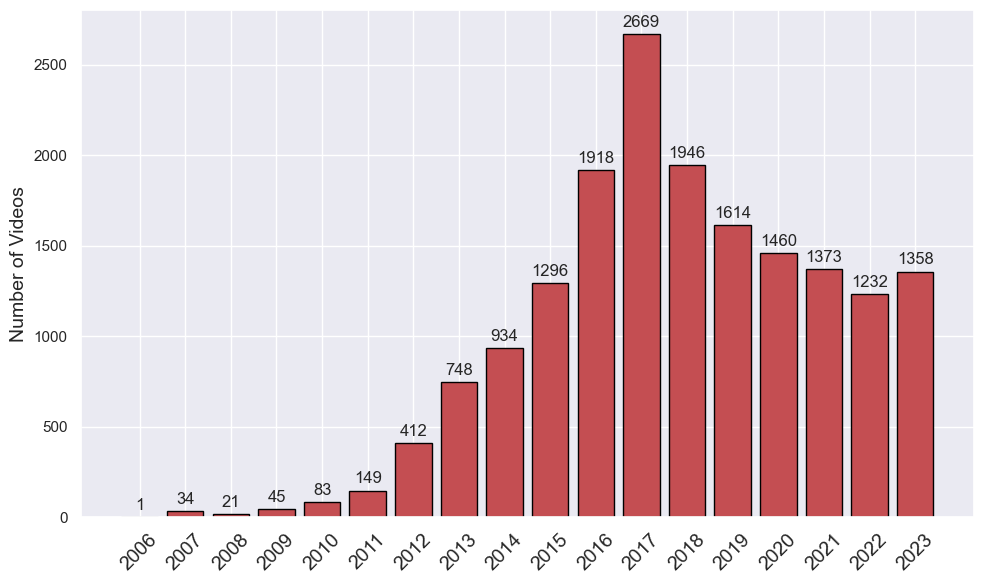

In [87]:
import matplotlib.pyplot as plt
from toxmon import utils

utils.setup_visualization()  # Setup the visualization

# Creating the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(
    videos_per_year.index,
    videos_per_year.values,
    alpha=1,
    color="C3",
    edgecolor="black",
)

# Add annotations to the bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(
        f"{int(height)}",  # Integer annotation for count
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),  # 3 points vertical offset
        textcoords="offset points",
        ha="center",
        va="bottom",
    )

# Set labels and ticks
plt.ylabel("Number of Videos", fontsize=14)
plt.xticks(videos_per_year.index, rotation=45, fontsize=14)

plt.tight_layout()
utils.generate_latex_figure(
    plt.gcf(),
    filename="videos_per_year",
    figure_caption="Number of Videos per Year",
    figure_label="fig:videos_per_year",
)

# plt.show()

In [33]:

\begin{figure}[htbp]
\centering
\includegraphics[width=\linewidth]{figures/videos_per_year}
\caption{Number of Videos per Year}
\label{fig:videos_per_year}
\end{figure}


In [63]:
df_videos["published_at"] = pd.to_datetime(df_videos["published_at"], format="mixed", utc=True)

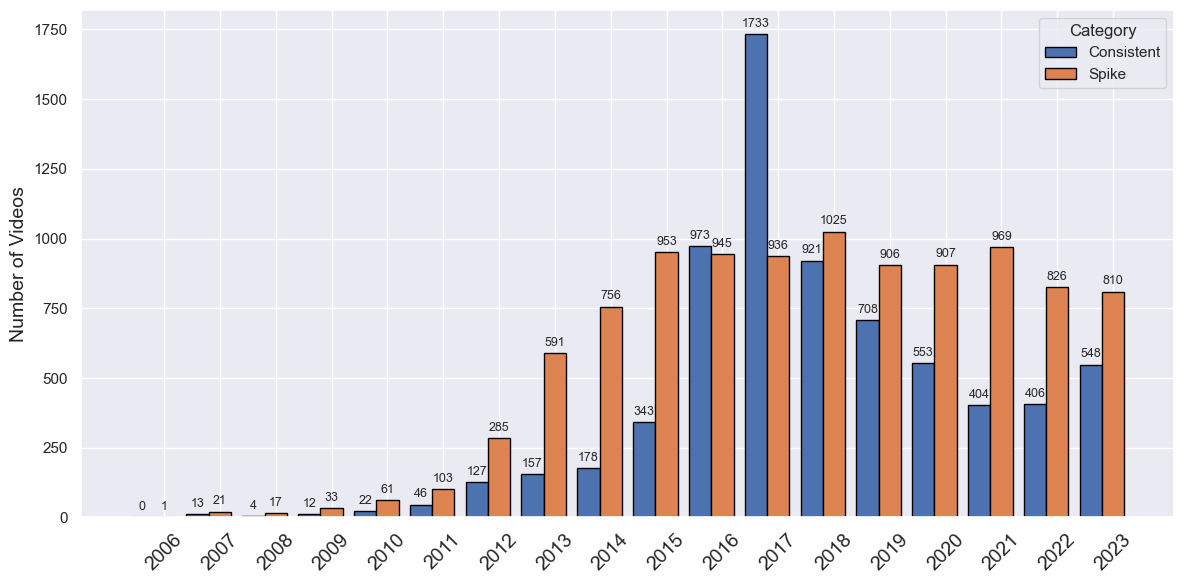

In [88]:
import matplotlib.pyplot as plt
import pandas as pd
from toxmon import utils

# Setup the visualization environment
utils.setup_visualization()

# Group by year and category
grouped_data = (
    df_videos.groupby([df_videos["published_at"].dt.year, "category"])
    .size()
    .unstack(fill_value=0)
)

# Creating the bar plot with separate bars per category
plt.figure(figsize=(12, 6))

# Determine the number of categories and create an array of positions
num_categories = len(grouped_data.columns)
positions = range(len(grouped_data))

# Width of each bar
bar_width = 0.8 / num_categories

# Plot bars for each category
for i, category in enumerate(grouped_data.columns):
    bars = plt.bar(
        [p + bar_width * i for p in positions],
        grouped_data[category],
        width=bar_width,
        label=category,
        alpha=1,
        edgecolor="black",
    )

    # Add label annotations to each bar
    for bar in bars:
        height = bar.get_height()
        plt.annotate(
            f"{int(height)}",
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=9,
        )

# Add annotations, labels, and legend
plt.ylabel("Number of Videos", fontsize=14)
# plt.xlabel("Year", fontsize=14)
plt.xticks(
    [p + bar_width * (num_categories / 2) for p in positions],
    grouped_data.index,
    rotation=45,
    fontsize=14,
)
plt.legend(title="Category")

plt.tight_layout()
utils.generate_latex_figure(
    plt.gcf(),
    filename="videos_per_year_per_category",
    figure_caption="Number of videos published per year split by drama category.",
    figure_label="fig:videos_per_year_per_category",
)

# Show the plot
plt.show()

In [68]:

\begin{figure*}[htbp]
\centering
\includegraphics[width=\linewidth]{figures/videos_per_year_per_category}
\caption{Number of videos published per year split by drama category.}
\label{fig:videos_per_year}
\end{figure*}


1358